In [1]:
path = '../phd-model-process/'

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sp
import scipy.stats as st

from helpers_pd import *

# Plotting
import seaborn as sns
sns.set()
# import seaborn as sns; sns.set(style="ticks", color_codes=True)
# sns.set(style="darkgrid")
import matplotlib.pyplot as plt
# plt.style.use('seaborn-white')

from matplotlib.patches import Ellipse, Rectangle

In [2]:
palette = ["#F44336", '#673AB7', '#3F51B5', '#009688', '#FF9800', '#4CAF50', '#03A9F4']
# red, purple, indigo, teal-green, orange, green, light-blue
# https://matplotlib.org/users/dflt_style_changes.html

# Extracting observed Conc.

## Define transect

In [3]:
obs_d13c = pd.read_table(path + 'observations/d13c_bulk_cal.tss')
obs_conc = pd.read_table(path + 'observations/conc_bulk_cal.tss')
p_b = pd.read_table(path + 'observations/p_bAve.tss')
obs_d13c.head()

,Jdays,DayMoYr,IDcal,d13C,d13C.SD
0,188,2016-04-05,B-188,-31.225186,0.640023
1,197,2016-04-14,B-197,-31.200375,0.303478
2,201,2016-04-18,B-201,-31.496359,0.390947
3,209,2016-04-26,B-209,-31.239331,0.542286
4,216,2016-05-03,B-216,-30.682124,0.434045


# Selecting indexes

In [4]:
gen = 'Gen10'
df3 = get_data(gen=gen) # , v="0920"
print(len(df3))
# Last printed version: v="1017" (Oct. 17) ~ 3250 sets

4825


In [5]:
df3["Gen"] = gen
# df4["Gen"] = "Gen4"
# df = pd.concat([df3, df4])
df = df3

In [35]:
df3.head(2)

,BIAS-d13C-blk,NSE-CONC-tot,NSE-CONC-tra,f_evap,NSE-CONC-blk,BIAS-CONC-blk,KGE-d13C-det,NSE-Q_out,NSE-d13C-tot,cZ0Z1,...,NSE-CONC-det,gamma01,MAE-CONC-blk,k_oc,epsilon_iso,MAE-d13C_out,beta_moisture,dt_50_ab,Gen,Name
LHS_be1fix61/1/,2.045865,0.468665,-0.096955,0.528609,-0.497637,64.411314,0.724614,0.222115,-0.135406,0.075965,...,0.594402,0.388470,1.792632,559.581116,2.131629,1.455996,0.756646,222.526421,Gen10,Gen10/LHS_be1fix61/1/
LHS_be1fix61/10/,-11.573154,0.541273,-0.221362,0.183035,-0.170124,-49.910734,-5.586947,0.402975,-66.664695,0.342539,...,0.710816,0.262011,1.457559,1009.675386,4.030861,4.811547,0.268687,240.647614,Gen10,Gen10/LHS_be1fix61/10/


In [6]:
# Index names
df['Name'] = df['Gen'] + "/" + df.index
df = df.set_index('Name')
# 'LHS_s2fix7/10/' in list(df.index)

In [7]:
df['k_d'] = df.loc[:, 'k_oc'] * df.loc[:,'f_oc']
# Combined outlet and transects KGE Concentrations and d13C
df['KGE-SM'] = (df.loc[:, 'KGE-CONC_out'] + df.loc[:, 'KGE-CONC-tra'])/2.0  
df['KGE-d13C'] = (df.loc[:, 'KGE-d13C_out'] + df.loc[:, 'KGE-d13C-tra'])/2.0
df['epsilon_iso'] *= -1

In [8]:
dfs = df[['Model', 'Gen',
          'dt_50_ref',
          'dt_50_ab',
#           'f_evap',
          'epsilon_iso',
          'beta_moisture',
          'KGE-CONC-blk','KGE-d13C-blk',
          'KGE-CONC_out','KGE-d13C_out',
          'KGE-SM', 'KGE-d13C',
          'KGE-Q_out'
          ]]

In [9]:
cst = .3
dfs['Constraint'] = dfs.apply(WithIsoKGE, args=(cst,), axis=1)

# Filter
dfs = dfs.loc[(dfs['Gen'] ==  gen)]

# Global
# ff = dfs.loc[(dfs['KGE-SM'] > 0.4)] # Try 25 with more data points
# ff_c = dfs.loc[(dfs['KGE-SM'] > 0.4) & (dfs['KGE-d13C'] >  cst)]

# Soil
ff = dfs.loc[(dfs['KGE-CONC-blk'] > 0.60) & (dfs['KGE-Q_out'] >  0.50)] # Try 25 with more data points
ff_c = dfs.loc[(dfs['KGE-CONC-blk'] > 0.50) & (dfs['KGE-d13C-blk'] >  0.70) & (dfs['KGE-Q_out'] >  0.545)]
# ff_c = dfs.loc[(dfs['KGE-CONC-blk'] > 0.00) & (dfs['KGE-d13C-blk'] >  0.85) & (dfs['KGE-Q_out'] >  0.50)]

# Outlet
# ff = dfs.loc[(dfs['KGE-CONC_out'] > 0.30)] # Try 25 with more data points
# ff_c = dfs.loc[(dfs['KGE-CONC_out'] > 0.30) & (dfs['KGE-d13C_out'] >  0.3)]

print(len(dfs), len(ff), len(ff_c))
# print(df['f_evap'].mean(), ff['f_evap'].mean(), ff_c['f_evap'].mean())
ff.tail()


(4825, 672, 214)


,Model,Gen,dt_50_ref,dt_50_ab,epsilon_iso,beta_moisture,KGE-CONC-blk,KGE-d13C-blk,KGE-CONC_out,KGE-d13C_out,KGE-SM,KGE-d13C,KGE-Q_out,Constraint
Name,,,,,,,,,,,,,,
Gen10/LHS_sc3var65/1/,var,Gen10,21.694049,109.194525,-1.710839,0.598516,0.676392,0.562267,-6.929376,-0.940183,-3.108623,-0.141510,0.686459,NC
Gen10/LHS_sc3var65/20/,var,Gen10,8.003322,126.760888,-0.934788,0.937672,0.659368,0.527435,-0.435029,-0.957716,0.054468,-0.077621,0.574184,NC
Gen10/LHS_sc3var65/37/,var,Gen10,11.763135,70.182429,-2.039693,0.635347,0.793995,0.853291,0.227292,-0.763822,0.484141,-0.103666,0.540645,NC
Gen10/LHS_sc3var65/46/,var,Gen10,9.572930,177.687580,-1.602098,0.254020,0.629770,0.578026,0.129056,0.016420,0.298727,0.329130,0.688052,WC
Gen10/LHS_sc3var65/8/,var,Gen10,15.848436,331.997634,-2.604415,0.308299,0.756996,0.895474,-5.082149,-3.389144,-2.145471,-1.395518,0.567520,NC


In [10]:
print(len(ff_c.loc[(ff_c['Model'] == 'var')]), len(ff_c.loc[(ff_c['Model'] == 'fix')]))

(92, 122)


In [11]:
ff_c.loc[(ff_c['Model'] == 'var')]['dt_50_ref'].mean()

15.909332341426616

In [12]:
ff_c.loc[(ff_c['Model'] == 'fix')]['dt_50_ref'].mean()

27.47458363042129

In [13]:
print("Max CONC: Var, Fix")
print(ff_c.loc[(ff_c['Model'] == 'var')]['KGE-CONC-blk'].max(), 
      ff_c.loc[(ff_c['Model'] == 'fix')]['KGE-CONC-blk'].max())

Max CONC: Var, Fix
(0.8024044844381782, 0.7978054162535689)


In [14]:
print("Max d13C: Var, Fix")
print(ff_c.loc[(ff_c['Model'] == 'var')]['KGE-d13C-blk'].max(), 
      ff_c.loc[(ff_c['Model'] == 'fix')]['KGE-d13C-blk'].max())

Max d13C: Var, Fix
(0.9491408401413893, 0.939173826191367)


In [15]:
print("Maximum Q")
print(df['KGE-Q_out'].max(), df['NSE-Q_out'].max()) 
print("Maximum Conc.")
print(df['KGE-CONC-blk'].max(), df['KGE-CONC_out'].max(), df['KGE-SM'].max()) 
print("Maximum d13C")
print(df['KGE-d13C-blk'].max(), df['KGE-d13C_out'].max(), df['KGE-d13C'].max()) 

Maximum Q
(0.769832923058568, 0.5284275029940944)
Maximum Conc.
(0.804979369020457, 0.483226275596356, 0.5760310071679046)
Maximum d13C
(0.9587708109826051, 0.6328847080874456, 0.7355584509288327)


## Var vs Fix
### Panel A (conc) & B (delta)

In [16]:
# GRAPH A & B
##############################
# For validation CIs
# wc = ff_c.index[(ff_c['Constraint'] == 'WC')].tolist() #[0]
wc = ff_c.index

sets_wc = get_sets_bulk(wc, path, p_b) # df

time_wc = sets_wc.filter(like="Jdays") # X

conc_wc = sets_wc.filter(like='Conc')
conc_fix = conc_wc.filter(like='fix') # Y 
conc_var = conc_wc.filter(like='var') # Y

d13c_wc = sets_wc.filter(like='d13C')
d13c_fix = d13c_wc.filter(like='fix')
d13c_var = d13c_wc.filter(like='var')


In [17]:
print(len(list(conc_fix)), len(list(conc_var)))

(122, 92)


In [18]:
# Time and Conc/delta (merged)
conc_tfix = pd.concat([time_wc, conc_fix], axis=1, join='inner')
conc_tvar = pd.concat([time_wc, conc_var], axis=1, join='inner')

d13c_tfix = pd.concat([time_wc, d13c_fix], axis=1, join='inner')
d13c_tvar = pd.concat([time_wc, d13c_var], axis=1, join='inner')

# Stats as df
conc_tfix_all = get_stats_bulk(conc_tfix, 'Conc', 'Fix')
conc_tvar_all = get_stats_bulk(conc_tvar, 'Conc', 'Var')

d13c_tfix_all = get_stats_bulk(d13c_tfix, 'd13C', 'Fix')
d13c_tvar_all = get_stats_bulk(d13c_tvar, 'd13C', 'Var')

### Panel C (DT50) & D ($\theta$, Temp)

In [19]:
# Graph C & D
# For moisture/temp graphs
fix_list = ff_c.index[(ff_c['Model'] == 'fix')].tolist() #[0]
var_list = ff_c.index[(ff_c['Model'] == 'var')].tolist() #[0]

# Extract
# Bulk
deg_fix = get_sets(fix_list, path, "resW_z0_DT50.tss", "DT50")
tmp_fix = get_sets(fix_list, path, "resW_z0_Temp.tss", "Temp")
moi_fix = get_sets(fix_list, path, "resW_z0_theta.tss", "Theta")

deg_var = get_sets(var_list, path, "resW_z0_DT50.tss", "DT50-z0")
deg_var_z1 = get_sets(var_list, path, "resW_z1_DT50.tss", "DT50-z1")
deg_var_z2 = get_sets(var_list, path, "resW_z2_DT50.tss", "DT50-z2")

tmp_var = get_sets(var_list, path, "resW_z0_Temp.tss", "Temp-z0")
tmp_var_z1 = get_sets(var_list, path, "resW_z1_Temp.tss", "Temp-z1")
tmp_var_z2 = get_sets(var_list, path, "resW_z2_Temp.tss", "Temp-z2")

moi_var = get_sets(var_list, path, "resW_z0_theta.tss", "Theta-z0")
moi_var_z1 = get_sets(var_list, path, "resW_z1_theta.tss", "Theta-z1")
moi_var_z2 = get_sets(var_list, path, "resW_z2_theta.tss", "Theta-z2")

# Z0 - DT50 Transects
deg_fix_nor = get_sets(fix_list, path, "resW_z0_DT50_nor.tss", "DT50-nor")
deg_fix_val = get_sets(fix_list, path, "resW_z0_DT50_val.tss", "DT50-val")
deg_fix_sou = get_sets(fix_list, path, "resW_z0_DT50_sou.tss", "DT50-sou")
deg_var_nor = get_sets(var_list, path, "resW_z0_DT50_nor.tss", "DT50-nor")
tmp_var_nor = get_sets(var_list, path, "resW_z0_temp_nor.tss", "Temp-nor")
moi_var_nor = get_sets(var_list, path, "resW_z0_theta_nor.tss", "Theta-nor")

deg_var_val = get_sets(var_list, path, "resW_z0_DT50_val.tss", "DT50-val")
tmp_var_val = get_sets(var_list, path, "resW_z0_temp_val.tss", "Temp-val")
moi_var_val = get_sets(var_list, path, "resW_z0_theta_val.tss", "Theta-val")

deg_var_sou = get_sets(var_list, path, "resW_z0_DT50_sou.tss", "DT50-sou")
tmp_var_sou = get_sets(var_list, path, "resW_z0_temp_sou.tss", "Temp-sou")
moi_var_sou = get_sets(var_list, path, "resW_z0_theta_sou.tss", "Theta-sou")

# Z1 - DT50 Transects
deg_fix_nor_z1 = get_sets(fix_list, path, "resW_z1_DT50_nor.tss", "DT50-nor-z1")
deg_fix_val_z1 = get_sets(fix_list, path, "resW_z1_DT50_val.tss", "DT50-val-z1")
deg_fix_sou_z1 = get_sets(fix_list, path, "resW_z1_DT50_sou.tss", "DT50-sou-z1")
deg_var_nor_z1 = get_sets(var_list, path, "resW_z1_DT50_nor.tss", "DT50-nor-z1")
deg_var_val_z1 = get_sets(var_list, path, "resW_z1_DT50_val.tss", "DT50-val-z1")
deg_var_sou_z1 = get_sets(var_list, path, "resW_z1_DT50_sou.tss", "DT50-sou-z1")

# Stats
stat_fix = [get_stats_df(deg_fix), get_stats_df(tmp_fix), get_stats_df(moi_fix)]

stat_var = [get_stats_df(deg_var), get_stats_df(tmp_var), get_stats_df(moi_var)]
# z1
stat_var_z1 = [get_stats_df(deg_var_z1), get_stats_df(tmp_var_z1), get_stats_df(moi_var_z1)]
# z2
stat_var_z2 = [get_stats_df(deg_var_z2), get_stats_df(tmp_var_z2), get_stats_df(moi_var_z2)]

# # z0
stat_fix_nor = [get_stats_df(deg_fix_nor)]
stat_fix_val = [get_stats_df(deg_fix_val)]
stat_fix_sou = [get_stats_df(deg_fix_sou)]

stat_var_nor = [get_stats_df(deg_var_nor), get_stats_df(tmp_var_nor), get_stats_df(moi_var_nor)]
stat_var_val = [get_stats_df(deg_var_val), get_stats_df(tmp_var_val), get_stats_df(moi_var_val)]
stat_var_sou = [get_stats_df(deg_var_sou), get_stats_df(tmp_var_sou), get_stats_df(moi_var_sou)]

# # z1
stat_fix_nor_z1 = [get_stats_df(deg_fix_nor_z1)]
stat_fix_val_z1 = [get_stats_df(deg_fix_val_z1)]
stat_fix_sou_z1 = [get_stats_df(deg_fix_sou_z1)]

stat_var_nor_z1 = [get_stats_df(deg_var_nor_z1)]
stat_var_val_z1 = [get_stats_df(deg_var_val_z1)]
stat_var_sou_z1 = [get_stats_df(deg_var_sou_z1)]

In [20]:
# Test
conc_tfix_all.head() # Graph A
# df1 # Graph C

,Jdays,mean,high,low,max,min,sd,IDcal,Type
0,166,0.075308,0.075581,0.075035,0.075446,0.074804,0.000137,B-166,Fix
1,167,0.081102,0.081689,0.080514,0.081400,0.080020,0.000294,B-167,Fix
2,168,0.080779,0.081656,0.079903,0.081224,0.079167,0.000438,B-168,Fix
3,169,0.080459,0.081621,0.079297,0.081049,0.078324,0.000581,B-169,Fix
4,170,0.080141,0.081586,0.078695,0.080874,0.077491,0.000723,B-170,Fix


In [21]:
# Isotopes
# d13c_wc = sets_wc.filter(like='d13C')
# d13c_fix = d13c_wc.filter(like='fix')
# d13c_var = d13c_wc.filter(like='var')
# # conc_nc = sets_nc.filter(like='Conc')

# d13c_tfix = pd.concat([time_wc, d13c_fix], axis=1, join='inner')
# d13c_tvar = pd.concat([time_wc, d13c_var], axis=1, join='inner')

# d13c_tfix_all = get_stats_bulk(d13c_tfix, 'd13C', 'Fix')
# d13c_tvar_all = get_stats_bulk(d13c_tvar, 'd13C', 'Var')

## Merge CI's with obs, get arrays (Graph A & B)

In [22]:
conc_tvar_merged = pd.merge(conc_tvar_all, obs_conc, how='outer', on='IDcal')
conc_tfix_merged = pd.merge(conc_tfix_all, obs_conc, how='outer', on='IDcal')

d13c_tvar_merged = pd.merge(d13c_tvar_all, obs_d13c, how='outer', on='IDcal')
d13c_tfix_merged = pd.merge(d13c_tfix_all, obs_d13c, how='outer', on='IDcal')

# Observed Conc
time = np.array(conc_tvar_merged['Jdays_x']-171)
arr_obs_conc = np.array(conc_tvar_merged['ug.g'])
arr_err = np.array(conc_tvar_merged['ug.g.SD'])

# Observed d13C
arr_obs_d13c = np.array(d13c_tvar_merged['d13C'])
arr_err_d13c = np.array(d13c_tvar_merged['d13C.SD'])

# Variable model
var_conc_mean = np.array(conc_tvar_merged['mean'])
var_conc_high = np.array(conc_tvar_merged['high'])
var_conc_low = np.array(conc_tvar_merged['low'])

var_d13c_mean = np.array(d13c_tvar_merged['mean'])
var_d13c_high = np.array(d13c_tvar_merged['high'])
var_d13c_low = np.array(d13c_tvar_merged['low'])

# Fix model
fix_conc_mean = np.array(conc_tfix_merged['mean'])
fix_conc_high = np.array(conc_tfix_merged['high'])
fix_conc_low = np.array(conc_tfix_merged['low'])

fix_d13c_mean = np.array(d13c_tfix_merged['mean'])
fix_d13c_high = np.array(d13c_tfix_merged['high'])
fix_d13c_low = np.array(d13c_tfix_merged['low'])



### ARIL 
#### Resolution of predictive distribution, how wide are the CIs?
ARIL should be as small as possible

In [23]:
conc_tvar_merged['ARIL'] = (conc_tvar_merged['high'] - conc_tvar_merged['low'])/conc_tvar_merged['ug.g']
d13c_tvar_merged['ARIL'] = (d13c_tvar_merged['low'] - d13c_tvar_merged['high'])/d13c_tvar_merged['d13C']

ARIL_var_conc = conc_tvar_merged['ARIL'].sum()/len(obs_conc)
ARIL_var_d13c = d13c_tvar_merged['ARIL'].sum()/len(obs_d13c)

print(ARIL_var_conc, ARIL_var_d13c)

(1.3025228222140655, 0.045342412343637103)


In [24]:
conc_tfix_merged['ARIL'] = (conc_tfix_merged['high'] - conc_tfix_merged['low'])/conc_tfix_merged['ug.g']
d13c_tfix_merged['ARIL'] = (d13c_tfix_merged['low'] - d13c_tfix_merged['high'])/d13c_tfix_merged['d13C']

ARIL_fix_conc = conc_tfix_merged['ARIL'].sum()/len(obs_conc)
ARIL_fix_d13c = d13c_tfix_merged['ARIL'].sum()/len(obs_d13c)
print(ARIL_fix_conc, ARIL_fix_d13c)

(0.9721706059523203, 0.043404956517533275)


### PCI
#### (Reliability of uncertainty interval estimates)
The higher the value (better), the more number of observations that are contained within the p confidence interval.

In [25]:
def count_conc(row):
    if row['high'] >= row['ug.g']:
        if row['low'] <= row['ug.g']:
            value = 1.
        else:
            value = 0.
    else:
        value = 0.
    return value

def count_delta(row):
    if row['high'] >= row['d13C']:
        if row['low'] <= row['d13C']:
            value = 1.
        else:
            value = 0.
    else:
        value = 0.
    return value

In [26]:
conc_tfix_merged['c_conc'] = conc_tfix_merged.apply(lambda row: count_conc(row), axis=1)
conc_tvar_merged['c_conc'] = conc_tvar_merged.apply(lambda row: count_conc(row), axis=1)

d13c_tfix_merged['c_d13c'] = d13c_tfix_merged.apply(lambda row: count_delta(row), axis=1)
d13c_tvar_merged['c_d13c'] = d13c_tvar_merged.apply(lambda row: count_delta(row), axis=1)

In [27]:
PCI_fix_conc = conc_tfix_merged['c_conc'].sum()/float(len(conc_tfix_merged))
PCI_var_conc = conc_tvar_merged['c_conc'].sum()/float(len(conc_tvar_merged))

PCI_fix_d13c = d13c_tfix_merged['c_d13c'].sum()/float(len(d13c_tfix_merged))
PCI_var_d13c = d13c_tvar_merged['c_d13c'].sum()/float(len(d13c_tvar_merged))

In [28]:
print(PCI_fix_conc, PCI_var_conc)
print(PCI_fix_d13c, PCI_var_d13c)

(0.09917355371900827, 0.10743801652892562)
(0.049586776859504134, 0.05785123966942149)


### PUCI
Should be as high as possible (the higher the PUCI, the lower the uncertainty of 95% confidence)

In [29]:
PUCI_fix_conc = round((1.-abs(PCI_fix_conc-0.95))/ARIL_fix_conc, 1)
PUCI_var_conc = round((1.-abs(PCI_var_conc-0.95))/ARIL_var_conc, 1)

PUCI_fix_d13c = round((1.-abs(PCI_fix_d13c-0.95))/ARIL_fix_d13c, 1)
PUCI_var_d13c = round((1.-abs(PCI_var_d13c-0.95))/ARIL_var_d13c, 1)

print(PUCI_fix_conc, PUCI_var_conc)
print(PUCI_fix_d13c, PUCI_var_d13c)

(0.2, 0.1)
(2.3, 2.4)


In [30]:
# Variable DT50 mean (mean of mean) during the first 50 days 
print(stat_var[0]['mean'][0:50].mean(),
      stat_var[0]['mean'][0:50].std())

(38.54792058695652, 22.6467216489838)


## Convert to arrays (Graph C & D)

In [31]:
deg_mean_fix = np.array(stat_fix[0]['mean'])
deg_high_fix = np.array(stat_fix[0]['high'])
deg_low_fix = np.array(stat_fix[0]['low'])

deg_mean_var = np.array(stat_var[0]['mean'])
deg_high_var = np.array(stat_var[0]['high'])
deg_low_var = np.array(stat_var[0]['low'])

# Z0
deg_mean_var_nor = np.array(stat_var_nor[0]['mean'])
tmp_mean_var_nor = np.array(stat_var_nor[1]['mean'])
moi_mean_var_nor = np.array(stat_var_nor[2]['mean'])

deg_mean_var_val = np.array(stat_var_val[0]['mean'])
tmp_mean_var_val = np.array(stat_var_val[1]['mean'])
moi_mean_var_val = np.array(stat_var_val[2]['mean'])

deg_mean_var_sou = np.array(stat_var_sou[0]['mean'])
tmp_mean_var_sou = np.array(stat_var_sou[1]['mean'])
moi_mean_var_sou = np.array(stat_var_sou[2]['mean'])

# Z1
deg_mean_var_nor_z1 = np.array(stat_var_nor_z1[0]['mean'])
deg_mean_var_val_z1 = np.array(stat_var_val_z1[0]['mean'])
deg_mean_var_sou_z1 = np.array(stat_var_sou_z1[0]['mean'])

# Z2
deg_mean_var_z2 = np.array(stat_var_z2[0]['mean'])
deg_mean_var_z2 = np.array(stat_var_z2[0]['mean'])
deg_mean_var_z2 = np.array(stat_var_z2[0]['mean'])

tmp_mean_fix = np.array(stat_fix[1]['mean'])
tmp_high_fix = np.array(stat_fix[1]['high'])
tmp_low_fix = np.array(stat_fix[1]['low'])

tmp_mean_var = np.array(stat_var[1]['mean']) # z0
tmp_mean_var_z1 = np.array(stat_var_z1[1]['mean']) # z1
tmp_mean_var_z2 = np.array(stat_var_z2[1]['mean']) # z2

tmp_high_var = np.array(stat_var[1]['high'])
tmp_low_var = np.array(stat_var[1]['low'])

moi_mean_fix = np.array(stat_fix[2]['mean'])
moi_high_fix = np.array(stat_fix[2]['high'])
moi_low_fix = np.array(stat_fix[2]['low'])

moi_mean_var = np.array(stat_var[2]['mean']) # z0
moi_mean_var_z1 = np.array(stat_var_z1[2]['mean']) # z1
moi_mean_var_z2 = np.array(stat_var_z2[2]['mean']) # z2

moi_high_var = np.array(stat_var[2]['high'])
moi_low_var = np.array(stat_var[2]['low'])

# tmp_mean_var*27.
# moi_mean_var

https://python-graph-gallery.com/25-histogram-with-several-variables-seaborn/

https://matplotlib.org/users/dflt_style_changes.html

## Observations for Panel C

In [32]:
grav = pd.read_csv(path + 'observations/theta_grav.csv', sep=',')
pb_r = pd.read_csv(path + 'observations/pb_range.csv', sep=',')
pb_merged = pd.merge(pb_r, grav, how='inner', on='Date')

pb_merged['theta'] = pb_merged['theta_grav']*pb_merged['pb_ave']
pb_merged['theta_min']= pb_merged['theta_grav']*pb_merged['pb_min']
pb_merged['theta_max']= pb_merged['theta_grav']*pb_merged['pb_max']


theta_time = np.array(pb_merged['Jdays'])-171
theta = np.array(pb_merged['theta'])
theta_min = np.array(pb_merged['theta']) - np.array(pb_merged['theta_min'])
theta_max = np.array(pb_merged['theta_max']) - np.array(pb_merged['theta'])

In [33]:
pb_merged.head()

,Date,Jdays,pb_ave,pb_min,pb_max,Transect,theta_grav,theta,theta_min,theta_max
0,05/04/2016,189,1.032210,0.910801,1.157660,N,0.274022,0.282848,0.249579,0.317224
1,05/04/2016,189,1.032210,0.910801,1.157660,S,0.296556,0.306108,0.270103,0.343311
2,05/04/2016,189,1.032210,0.910801,1.157660,T,0.301670,0.311387,0.274762,0.349232
3,14/04/2016,198,1.062887,0.927687,1.204512,N,0.224297,0.238402,0.208077,0.270168
4,14/04/2016,198,1.062887,0.927687,1.204512,S,0.223267,0.237308,0.207122,0.268928


In [33]:
theta_sum = pb_merged[['Jdays', 'theta']]
grouped = theta_sum.groupby(['Jdays'], as_index=True)
# grouped.describe().head()
dfm = grouped.describe()
list(dfm)
# dfm.head(2)

[('theta', 'count'),
 ('theta', 'mean'),
 ('theta', 'std'),
 ('theta', 'min'),
 ('theta', '25%'),
 ('theta', '50%'),
 ('theta', '75%'),
 ('theta', 'max')]

In [34]:
theta_comp = np.array(dfm[('theta', 'mean')])
# theta_err = np.array(dfm[('theta', 'min')], dfm[('theta', 'max')])
# theta_err = np.array(dfm[('theta', '25%')], dfm[('theta', '75%')])
theta_err = np.array(dfm[('theta', 'std')]*2)
time_comp = np.array(dfm.index)-171

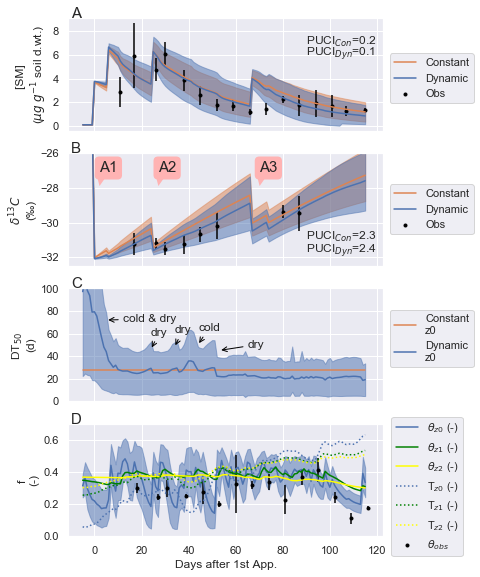

In [35]:
# sns.set(rc={'figure.figsize':(11.7, 8.27)})
# ES&T max width: 
# 1 column = 3.25in 
# 2 column = 7.0in 
sns.set_context("paper")
sns.set(rc={'figure.figsize':(7., 8.27)}) # Width, height, inches

fig = plt.figure()
fig.subplots_adjust(right=0.75)

ax1 = plt.subplot(411) # (tot Rows, tot cols, index)
ax2 = plt.subplot(412, sharex=ax1)
ax3 = plt.subplot(413, sharex=ax1)
ax4 = plt.subplot(414, sharex=ax1)

# axes = [plt.subplot(411), 
#         plt.subplot(412, sharex=ax1), 
#         plt.subplot(413, sharex=ax1), 
#         plt.subplot(414, sharex=ax1)
#        ]

# Shrink current axis by 20%
# boxes = [ax1.get_position(), 
#          ax2.get_position(), 
#          ax3.get_position(), 
#          ax4.get_position()]

# for i in range(len(boxes)):
#     axes[i].set_position([boxes[i].x0, boxes[i].y0, boxes[i].width * 0.5, boxes[i].height])

#####
# A
#####
# Fix Conc
ax1.plot(time, fix_conc_mean, label='Constant', c= "C1") #
ax1.fill_between(time, fix_conc_high, fix_conc_low,  color= "C1", alpha=0.5)

# Var Conc
ax1.plot(time, var_conc_mean, label='Dynamic', c= "C0") # 
ax1.fill_between(time, var_conc_high, var_conc_low, color= "C0", alpha=0.5)

## Hide Tick marks
plt.setp(ax1.get_xticklabels(), visible=False)

# Obs Conc
ax1.errorbar(time, arr_obs_conc, arr_err, c= "black")
ax1.scatter(time, arr_obs_conc, c="black", marker='.', label="Obs")

ax1.set_ylabel("[SM] \n($\mu g$ $g^{-1}$ soil d.wt.)")
# ax1.legend(loc="upper right")

ax1.annotate('PUCI$_{Dyn}$=' + str(PUCI_var_conc), 
             xy=(90, 6.), xycoords='data')

ax1.annotate('PUCI$_{Con}$=' + str(PUCI_fix_conc), 
             xy=(90, 6.9), xycoords='data')


#####
# B
#####
# Var d13c
ax2.plot(time, fix_d13c_mean, label='Constant', c= "C1") # c= "red", marker='.', linestyle=':'
ax2.fill_between(time, fix_d13c_high, fix_d13c_low,  color= "C1", alpha=0.5)

# Var d13c
ax2.plot(time, var_d13c_mean, label='Dynamic', c= "C0") # c= "red", marker='.', linestyle=':'
ax2.fill_between(time, var_d13c_high, var_d13c_low, color= "C0", alpha=0.5)

# Obs d13c
ax2.errorbar(time, arr_obs_d13c, arr_err_d13c, c= "black")
ax2.scatter(time, arr_obs_d13c, c= "black", marker='.', label="Obs")
ax2.set_ylabel("$\delta ^{13}C$ \n" + u'(\u2030)')
ax2.set_ylim(-32.5, -26.)
# ax2.set_xlabel("Days after 1st App.")
plt.setp(ax2.get_xticklabels(), visible=False)

ax2.annotate('A1', xy=(2, -28), 
                 xycoords='data', xytext=(0, 20), textcoords='offset points', 
                 size=15, va="center",
                 bbox=dict(boxstyle="round", fc=(1., .7, .7), ec="none"),
                 arrowprops=dict(arrowstyle="wedge,tail_width=1.", 
                                 fc=(1., .7, .7), ec="none", patchA=None, patchB=None, relpos=(.2, .5)
                                ))

ax2.annotate('A2', xy=(27, -28), 
                 xycoords='data', xytext=(0, 20), textcoords='offset points', 
                 size=15, va="center",
                 bbox=dict(boxstyle="round", fc=(1., .7, .7), ec="none"),
                 arrowprops=dict(arrowstyle="wedge,tail_width=1.", 
                                 fc=(1., .7, .7), ec="none", patchA=None, patchB=None, relpos=(.2, .5)
                                ))

ax2.annotate('A3', xy=(70, -28), 
                 xycoords='data', xytext=(0, 20), textcoords='offset points', 
                 size=15, va="center",
                 bbox=dict(boxstyle="round", fc=(1., .7, .7), ec="none"),
                 arrowprops=dict(arrowstyle="wedge,tail_width=1.", 
                                 fc=(1., .7, .7), ec="none", patchA=None, patchB=None, relpos=(.2, .5)
                                ))

ax2.annotate('PUCI$_{Dyn}$=' + str(PUCI_var_d13c), 
             xy=(90, -31.7), xycoords='data')

ax2.annotate('PUCI$_{Con}$=' + str(PUCI_fix_d13c), 
             xy=(90, -31.), xycoords='data')

#####
# C
#####
ax3.plot(time, deg_mean_fix, label='Constant\nz0', color="C1", linestyle='-')
ax3.plot(time, deg_mean_var, label='Dynamic\nz0', color="C0", linestyle='-')
ax3.fill_between(time, deg_low_var, deg_high_var, color="C0", alpha=0.5)

# ax3.plot(time, deg_mean_var_nor_z1, label='DT$_{50,z1}$ (Dynamic)', color="green", linestyle='-.')
# ax3.plot(time, deg_mean_var_z2, label='DT$_{50,z2}$ (Dynamic)', color="yellow", linestyle='-.')
ax3.legend()
ax3.set_ylim(0.0, 100.)
plt.setp(ax3.get_xticklabels(), visible=False)

ax3.set_ylabel("DT$_{50}$ \n(d)")

ax3.annotate('cold & dry', xy=(5, 72), xytext=(12, 73), arrowprops={'arrowstyle': '->', 'color': 'black'},va='center')
ax3.annotate('dry', xy=(24, 46), xytext=(24, 61), arrowprops={'arrowstyle': '->', 'color': 'black'},va='center')
ax3.annotate('dry', xy=(34, 48), xytext=(34, 63), arrowprops={'arrowstyle': '->', 'color': 'black'},va='center')
ax3.annotate('cold', xy=(44, 50), xytext=(44, 65), arrowprops={'arrowstyle': '->', 'color': 'black'},va='center')
ax3.annotate('dry', xy=(53, 45), xytext=(65, 50), arrowprops={'arrowstyle': '->', 'color': 'black'},va='center')


#####
# D
#####
m = ax4.plot(time, moi_mean_var, label='$\\theta_{z0}$ (-)', color="C0", linestyle='-') # c= "red", marker='.'
ax4.fill_between(time, moi_high_var, moi_low_var, color="C0", alpha=0.5)
ax4.plot(time, moi_mean_var_z1, label='$\\theta_{z1}$ (-)', color="green", linestyle='-') # c= "red", marker='.'
ax4.plot(time, moi_mean_var_z2, label='$\\theta_{z2}$ (-)', color="yellow", linestyle='-') # c= "red", marker='.'

ax4.plot(time, tmp_mean_var, label='T$_{z0}$ (-)', color="C0", linestyle=':') # c= "red", marker='.'
ax4.plot(time, tmp_mean_var_z1, label='T$_{z1}$ (-)', color="green", linestyle=':') # c= "red", marker='.'
ax4.plot(time, tmp_mean_var_z2, label='T$_{z2}$ (-)', color="yellow", linestyle=':') # c= "red", marker='.'
# ax4.fill_between(time, tmp_high_var, tmp_low_var, color="C3", alpha=0.5)



ax4.errorbar(time_comp, theta_comp, theta_err, c= "black", fmt='', linestyle='')
t = ax4.scatter(time_comp, theta_comp, c="black", marker='.', label="$\\theta_{obs}$", zorder=11)


ax1.legend(bbox_to_anchor=(0.94, .92),
           bbox_transform=plt.gcf().transFigure)
# ax2.legend(loc="upper right")
ax2.legend(bbox_to_anchor=(0.94, .70),
           bbox_transform=plt.gcf().transFigure)

ax3.legend(bbox_to_anchor=(0.94, .49),
           bbox_transform=plt.gcf().transFigure)

ax4.legend(ncol=1, bbox_to_anchor=(.755, .31), columnspacing=1,
           bbox_transform=plt.gcf().transFigure)
# Create the second legend and add the artist manually.
# from matplotlib.legend import Legend
# leg = Legend(ax4, [t], ['$\\theta_{obs}$'],
#              loc='upper left', bbox_to_anchor=(1.23, 1.05))
# ax4.add_artist(leg)

ax4.set_ylim(0.0, 0.7)
ax4.set_ylabel("f \n(-)")
ax4.set_xlabel("Days after 1st App.")
# ax4.legend()

ax1.annotate('A', fontsize=15,
            xy=(-10, 9.12), xycoords='data')
ax2.annotate('B', fontsize=15,
            xy=(-10, -25.98), xycoords='data')
ax3.annotate('C', fontsize=15,
            xy=(-10, 100.12), xycoords='data')
ax4.annotate('D', fontsize=15,
            xy=(-10, 0.7), xycoords='data')

##############
## Adjustments
plt.subplots_adjust(left=None, bottom=.1, right=None, top=.97,
                wspace=None, hspace=None)

# fig.savefig("Fig1_VarFix.pdf")